# An introduction to the simulator module

In [1]:
import numpy as np
import gwpy
import bilby
import sys
import matplotlib.pyplot as plt
import gwpy.timeseries
from scipy import optimize
import astropy.units as u
sys.path.insert(0,'..')
from pygwb.detector import Interferometer
from pygwb.network import Network
#from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator
%matplotlib inline

## Simulating data with the simulator module directly

### Spectrum to inject

Among the parameters the simulator module expects is the spectrum to be injected in the form of a gwpy.frequencyseries. This spectrum is the power spectral density (PSD) of the GW signal Below, we define such a spectrum for some injection value of $\Omega_{\rm ref}$ at a reference frequency $f_{\rm ref}$. We will take a relatively large value for $\Omega_{\rm ref}$ such that the signal is large enough to rise above the noise curve. Note that this function can be used to generate any power-law spectrum.

In [2]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 2/3
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0.si.value ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef, alpha1, fref, alpha2)

### Parameters for the simulation

For this tutorial, we will simulate 5 segments (N_segs) of duration 64 (duration) with a sampling frequency of 1024 Hz. This is specified below.

In [3]:
duration = 64 # duration of each segment of data (s)
N_segs = 5  # number of data segments to generate
sampling_frequency = 1024 # Hz

Furthermore, the simulator module expects a list of bilby interferometers for which the data needs to be simulated. For this tutorial, we decide to use H1 and L1 as an example. However, note that the data can be simulated for an arbitrary amount of detectors. One would simply add more detectors to the *ifo_list* below.

In [4]:
ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

We are now ready to simulate data. We consider two cases: one where only the signal is simulated and one where signal and noise are simulated. This can be controlled by the *no_noise* flag that can be passed to the simulator.

### CBC background

We now will add simulate CBC signals and add them to our simulated data.

In [5]:
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['chirp_mass'] = bilby.core.prior.Uniform(2, 30, name="chirp_mass")
priors['mass_ratio'] = 1.0
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['luminosity_distance'] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', 
                                                          minimum=10, maximum=100, 
                                                          unit='Mpc')
priors["geocent_time"] = bilby.core.prior.Uniform(0, duration*N_segs, name="geocent_time")

# create 20 injections
injections = priors.sample(20)



13:32 bilby INFO    : Using aligned spin prior
13:32 bilby INFO    : No prior given, using default BBH priors in /home/derek.davis/.conda/envs/pygwb_dev/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [6]:
import logging
logging.getLogger("bilby").setLevel(logging.WARNING)

simulator_cbc = Simulator(ifo_list, N_segs, duration = duration, injection_dict=injections, 
                                       sampling_frequency = sampling_frequency, no_noise=False)
data_cbc = simulator_cbc.generate_data()

2023-01-31 13:32:36.888 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:32:36.924 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ


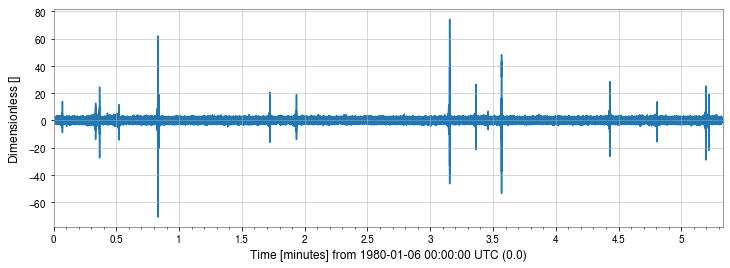

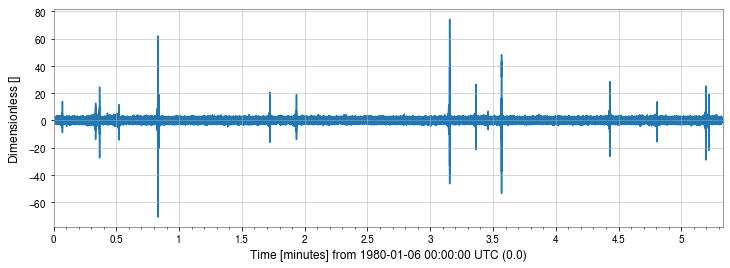

In [7]:
data_cbc[0].whiten().plot()

### continuous data

Let's now test our ability to generate two segments of data that are continuous. This can be done by setting `continuous=True`.

First, let's check what happens when `continuous=False`:

In [8]:
simulator_signal_and_noise0 = Simulator(ifo_list, N_segs, duration = duration, intensity_GW = Intensity_GW_inject, 
                                       sampling_frequency = sampling_frequency, no_noise=False, start_time=0, seed=1234, continuous=False)
data_signal_and_noise0 = simulator_signal_and_noise0.get_data_for_interferometers()
simulator_signal_and_noise1 = Simulator(ifo_list, N_segs, duration = duration, intensity_GW = Intensity_GW_inject,
                                       sampling_frequency = sampling_frequency, no_noise=False, start_time=N_segs*duration, seed=1234, continuous=False)
data_signal_and_noise1 = simulator_signal_and_noise1.get_data_for_interferometers()
data_combined = data_signal_and_noise0['H1'].append(data_signal_and_noise1['H1'], inplace=False)

2023-01-31 13:32:51.173 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:32:51.211 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ
2023-01-31 13:33:00.894 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:33:00.935 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ


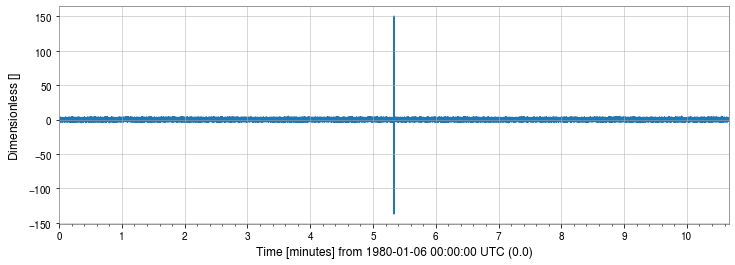

In [9]:
plot = data_combined.whiten().plot()

We can see that there is an impulse introduced at the point the two time series are joined due to the discontinuity!

Now let's try `continuous=True`:

In [10]:
simulator_signal_and_noise0_cont = Simulator(ifo_list, N_segs, duration = duration, intensity_GW = Intensity_GW_inject, 
                                       sampling_frequency = sampling_frequency, no_noise=False, start_time=0, seed=1234, continuous=True)
data_signal_and_noise0_cont = simulator_signal_and_noise0_cont.get_data_for_interferometers()
simulator_signal_and_noise1_cont = Simulator(ifo_list, N_segs, duration = duration, intensity_GW = Intensity_GW_inject, 
                                       sampling_frequency = sampling_frequency, no_noise=False, start_time=N_segs*duration, seed=1234, continuous=True)
data_signal_and_noise1_cont = simulator_signal_and_noise1_cont.get_data_for_interferometers()


2023-01-31 13:33:13.488 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:33:13.525 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ
2023-01-31 13:33:23.150 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:33:23.185 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ
2023-01-31 13:33:32.765 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:33:32.799 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ
2023-01-31 13:33:42.657 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 13:33:42.692 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ
2023-01-31 13:33:52.298 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel 

In [11]:
data_combined_cont = data_signal_and_noise0_cont['H1'].append(data_signal_and_noise1_cont['H1'], inplace=False)

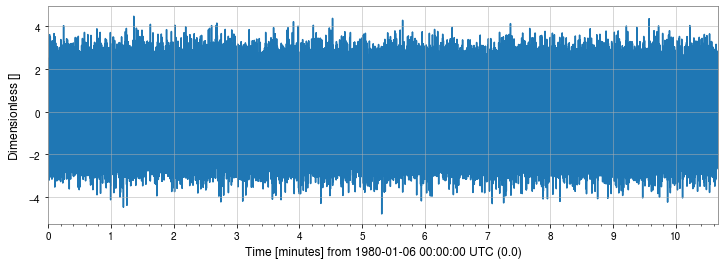

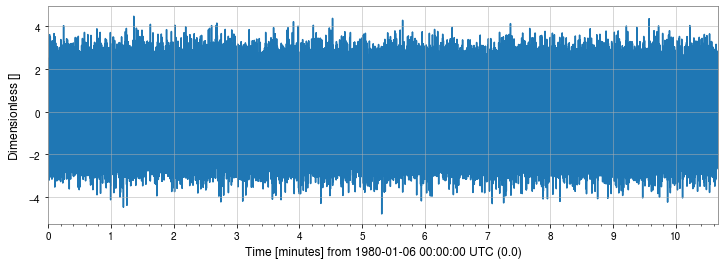

In [12]:
data_combined_cont.whiten().plot()

Everything now looks to be working just fine! Our data looks like one continuous segment of data even though we generated the data in two chunks. 